# Label Only Membership Inference (Revisited on points)

### Threat Model:

- **Black Box** access to an overfitted classifier with no access to actual $D_{train}$
- Predict API returns **only labels instead of confidence vectors**
- We have some insight on the training data distribution, $D_{out}$ , **but** $D_{train} \cap D_{out} = \varnothing$


### Attack Target: 
- Use a shadow model to attack local shadow models and extract membership leakage features
- Use data perturbations in order to exploit test/training data approximation relevancies to the classification boundaries.
- Perfom the boundary-based attack on the actual model

### Evaluation Target
- Score over $50\%$ accuracy
- Train attack model based on this assumption and compare with conf-vector attack

Implemented based on [this paper](https://arxiv.org/abs/2007.14321).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import math
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import regularizers

# for image interpolation
import scipy.ndimage.interpolation as interpolation

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report

from mia.attack_model import *
from mia.label_only import *
from mia.shadow_models import *
from mia.utilities import *
from mia.wrappers import ConfidenceVectorAttack

from tqdm import tqdm
import sys
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


## Target Model

### Model Architecture
- 2 layers of 32 $3\times 3$ Conv2D filters with Max Pooling
- 2 layers of 64 $3\times 3$ Conv2D filters with MaxPooling
- Dense Layer of 512 neurons
- Dense Output layer of 10 neurons
- Each layer has ReLU activation


In [2]:
D_TARGET_SIZE = 2500

In [3]:
def f_target(X_train, y_train, X_test=None, y_test=None, epochs=100):
  """
  Returns a trained target model, if test data are specified we will evaluate the model and print its accuracy
  """
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))

  model.add(layers.Flatten())
  model.add(layers.Dense(32, activation='relu'))

  model.add(layers.Dense(10))
  
  optimizer = keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  if X_test is None or y_test is None:
    history = model.fit(X_train, y_train, epochs=epochs, 
                    validation_split=0.2)
  else:
    history = model.fit(X_train, y_train, epochs=epochs, 
                    validation_data=(X_test, y_test))
  return model

In [4]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()
train_images = train_images.reshape((-1, 28, 28, 1))
test_images=test_images.reshape((-1, 28, 28, 1))

#shuffle the datasets
sample_i = np.random.choice(range(train_images.shape[0]), train_images.shape[0], replace=False)
train_images = train_images[sample_i]
train_labels = train_labels[sample_i]
sample_i = np.random.choice(range(test_images.shape[0]), test_images.shape[0], replace=False)
test_images = test_images[sample_i]
test_labels = test_labels[sample_i] 

# define the target's training dataset and the attacker's retrieved dataset
attacker_labels = np.concatenate((train_labels[D_TARGET_SIZE:], test_labels))
attacker_images = np.concatenate((train_images[D_TARGET_SIZE:], test_images))
target_images = train_images[:D_TARGET_SIZE]
target_labels = train_labels[:D_TARGET_SIZE]

In [5]:
train_images, eval_images, train_labels, eval_labels = train_test_split(target_images, target_labels, test_size=0.2, shuffle=True)
target_model = f_target(train_images, train_labels, eval_images, eval_labels, epochs=25) 

Epoch 1/25
63/63 [==============================] - 3s 18ms/step - loss: 3.6304 - accuracy: 0.3550 - val_loss: 1.2286 - val_accuracy: 0.5420
Epoch 2/25
63/63 [==============================] - 1s 11ms/step - loss: 1.1157 - accuracy: 0.6240 - val_loss: 0.8881 - val_accuracy: 0.7200
Epoch 3/25
63/63 [==============================] - 1s 12ms/step - loss: 0.6742 - accuracy: 0.7800 - val_loss: 0.6676 - val_accuracy: 0.7680
Epoch 4/25
63/63 [==============================] - 1s 11ms/step - loss: 0.4118 - accuracy: 0.8680 - val_loss: 0.4747 - val_accuracy: 0.8740
Epoch 5/25
63/63 [==============================] - 1s 11ms/step - loss: 0.2195 - accuracy: 0.9355 - val_loss: 0.5100 - val_accuracy: 0.8620
Epoch 6/25
63/63 [==============================] - 1s 10ms/step - loss: 0.1477 - accuracy: 0.9565 - val_loss: 0.3643 - val_accuracy: 0.9100
Epoch 7/25
63/63 [==============================] - 1s 12ms/step - loss: 0.0948 - accuracy: 0.9700 - val_loss: 0.3596 - val_accuracy: 0.9220
Epoch 8/25
63

In [12]:
N_SHADOWS = 5
D_SHADOW_SIZE = 1000

In [13]:
def f_shadow():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='tanh', input_shape=(28, 28, 1)))
  model.add(layers.MaxPooling2D((2, 2)))
  
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='tanh'))

  model.add(layers.Dense(10))
  
  optimizer = keras.optimizers.Adam()
  model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  return model

Epoch 1/25
21/21 [==============================] - 1s 15ms/step - loss: 1.2791 - accuracy: 0.5955 - val_loss: 0.6485 - val_accuracy: 0.8152
Epoch 2/25
21/21 [==============================] - 0s 7ms/step - loss: 0.3765 - accuracy: 0.9045 - val_loss: 0.4533 - val_accuracy: 0.8424
Epoch 3/25
21/21 [==============================] - 0s 9ms/step - loss: 0.1933 - accuracy: 0.9657 - val_loss: 0.3908 - val_accuracy: 0.8818
Epoch 4/25
21/21 [==============================] - 0s 9ms/step - loss: 0.1087 - accuracy: 0.9896 - val_loss: 0.3606 - val_accuracy: 0.8879
Epoch 5/25
21/21 [==============================] - 0s 8ms/step - loss: 0.0660 - accuracy: 0.9955 - val_loss: 0.3447 - val_accuracy: 0.8848
Epoch 6/25
21/21 [==============================] - 0s 7ms/step - loss: 0.0438 - accuracy: 1.0000 - val_loss: 0.3456 - val_accuracy: 0.9000
Epoch 7/25
21/21 [==============================] - 0s 7ms/step - loss: 0.0325 - accuracy: 1.0000 - val_loss: 0.3341 - val_accuracy: 0.8909
Epoch 8/25
21/21 [=

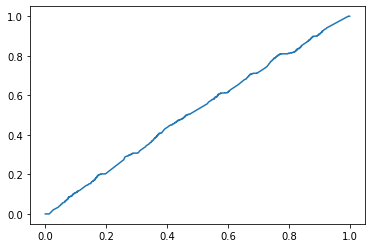

In [14]:
attack = ConfidenceVectorAttack(target_model, (train_images, train_labels), (attacker_images, attacker_labels), f_shadow, 
                                n_shadows=N_SHADOWS, D_shadow_size=D_SHADOW_SIZE)
attack.perform_attack()
attack.evaluate_attack()

# Extras

## Check target model's behaviour in perturbed images

In [9]:
def study_perturbations(model, X, y, rs, ts):
  diffs = []
  y_pred = target_predict(model, X)    
  for c in range(10):
    #  given class acquire the changes in perturbed input instances given the model
    idx = y_pred[:, 0] == c
    X_c = X[idx]
    y_pred_c = y_pred[idx]
    perturbed_labels = augmented_queries(model, X_c, y_pred_c, rs, ts)
    # Now we have to count how many labels diverge from the predicted label
    diff = len(perturbed_labels.reshape(-1)) - sum(perturbed_labels.reshape(-1)) # the labels are binary where 1 == y_pred = y_perturbed, otherwise 0
    diffs.append(int(100 * diff/len(perturbed_labels.reshape(-1)))) # append the percentage of changes in the class sample
    
  return diffs 

In [10]:
N_SAMPLES = 100
train_idx = np.random.choice(range(train_images.shape[0]), N_SAMPLES, replace=False)
test_idx = np.random.choice(range(attacker_images.shape[0]), N_SAMPLES, replace=False)

NameError: ignored

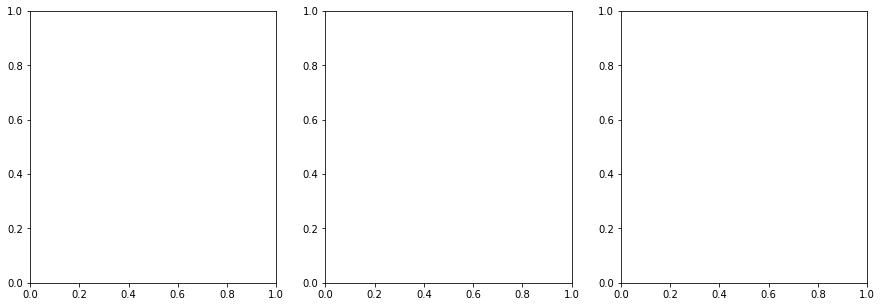

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# tests in D_in
diffs_per_class_D_in = study_perturbations(target_model, train_images[train_idx], train_labels[train_idx], r, d) 
total_diffs_in = sum(diffs_per_class_D_in)/10
axes[0].set_title('D_in predicted label divergence');
axes[0].barh(list(range(10)), diffs_per_class_D_in, tick_label=[f'Class-{i}' for i in range(10)])

# tests in D_out  
diffs_per_class_D_out= study_perturbations(target_model,attacker_images[test_idx],attacker_labels[test_idx], r, d)
total_diffs_out = sum(diffs_per_class_D_out)/10
axes[1].set_title('D_out predicted label divergence');
axes[1].barh(list(range(10)), diffs_per_class_D_out, tick_label=[f'Class-{i}' for i in range(10)])

axes[2].set_title('Total predicted label divergence percentage');
axes[2].barh([1, 0], [total_diffs_in, total_diffs_out], tick_label=['In', 'Out'])

plt.setp(axes, xticks=range(0, 101, 10), xticklabels=[f'{i}%' for i in range(0, 101, 10)])

We can conclude that $x \in D_{target}$ are more robust to perturbations, than any other instance not in target's training dataset. Nevertheless, whether the model is overfitted or not plays an important role to this training feature, meaning that the more overfit the model is the easier it gets to infer membership of tested instances. 

## Attack a perturbation trained model

- We will apply augmentations to the dataset and re-train the target model.
- The attacker **does not** know our augmentation settings, so he will train with a normal dataset of zero augmentations
- We want to measure the quality of the attack when the target tries to defend MIAs by adding perturbed images of data samples 

In [ ]:
# We will defend against the same rotations and translations that the attack models uses (worst case for the attacker)
rotates = create_rotates(r)
translates = create_translates(d)

X_train_aug = train_images
X_eval_aug = eval_images
y_train_aug = np.concatenate(tuple([train_labels] + [train_labels for rot in rotates] + [train_labels for tra in translates]))
y_eval_aug = np.concatenate(tuple([eval_labels] + [eval_labels for rot in rotates] + [eval_labels for tra in translates]))



for rot in rotates:
  aug_x = apply_augment(train_images, rot, 'r')
  X_train_aug = np.concatenate((X_train_aug,aug_x))
  aug_x = apply_augment(eval_images, rot, 'r')
  X_eval_aug = np.concatenate((X_eval_aug,aug_x))

for tra in translates:
  aug_x = apply_augment(train_images, tra, 'd')
  X_train_aug = np.concatenate((X_train_aug,aug_x))
  aug_x = apply_augment(eval_images, tra, 'd')
  X_eval_aug = np.concatenate((X_eval_aug ,aug_x))


In [ ]:

with tf.device('/gpu:0'):
  X_train_aug = tf.convert_to_tensor(X_train_aug)
  y_train_aug = tf.convert_to_tensor(y_train_aug)
  X_eval_aug = tf.convert_to_tensor(X_eval_aug)
  y_eval_aug = tf.convert_to_tensor(y_eval_aug)
  target_model = f_target(X_train_aug, y_train_aug, X_eval_aug, y_eval_aug, epochs=10) 

The model is quite overfitted so now all that is left is to evaluate the attack model we created before on the newly trained and "defended" target model with perturbations in the train dataset.

In [ ]:
D_in = attack_model.prepare_batch(target_model, train_images[:1000], train_labels[:1000], True)

D_out = attack_model.prepare_batch(target_model, attacker_images[:1000], attacker_labels[:1000], False)

attack_model.evaluate(np.concatenate((D_out[:, :-1], D_in[:, :-1])),  np.concatenate((D_out[:, -1], D_in[:, -1])), 10)

### Conclusion

To conclude if the model is more vulnerable, we must meassure the label divergence percentage in the adjusted-to-augmentations model.

In [ ]:
# test it onthe same data as we tested the non-adjusted to augmentation model
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# tests in D_in
diffs_per_class_D_in = study_perturbations(target_model, train_images[train_idx], train_labels[train_idx], r, d) 
total_diffs_in = sum(diffs_per_class_D_in)/10
axes[0].set_title('D_in predicted label divergence');
axes[0].barh(list(range(10)), diffs_per_class_D_in, tick_label=[f'Class-{i}' for i in range(10)])

# tests in D_out  
diffs_per_class_D_out= study_perturbations(target_model,attacker_images[test_idx],attacker_labels[test_idx], r, d)
total_diffs_out = sum(diffs_per_class_D_out)/10
axes[1].set_title('D_out predicted label divergence');
axes[1].barh(list(range(10)), diffs_per_class_D_out, tick_label=[f'Class-{i}' for i in range(10)])

axes[2].set_title('Total predicted label divergence percentage');
axes[2].barh([1, 0], [total_diffs_in, total_diffs_out], tick_label=['In', 'Out'])

plt.setp(axes, xticks=range(0, 101, 10), xticklabels=[f'{i}%' for i in range(0, 101, 10)])

We can see that the general percentage of predicted label divergence has fallen, **but** the confidence of the ML algorithm in predicting the label of perturbed instances of instances in $D_{target}$ is better that before and that is realized by the increase of the AUC value (~0.52 when before ~0.51). This means that the adjusted model is even more vulnerable and our attack predicts membership with high sensitivity to the predicted label changes. Next step is to run all with some defences on.